# Semantic segmentation-based analysis of atomic images

Author: Maxim Ziatdinov

Email: ziatdinovmax@gmail.com



---


This notebook shows how to apply a UNet-like neural network for semantic segmentation of atomic images.

---



Install AtomAI:

In [1]:
!pip install atomai
!pip install nanonispy  # to read the STM data

     |████████████████████████████████| 146 kB 11.9 MB/s 
     |████████████████████████████████| 193 kB 70.9 MB/s 
     |████████████████████████████████| 503 kB 53.0 MB/s 
     |████████████████████████████████| 865 kB 34.0 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174982 sha256=800e7222156b396a4e5eed96f46a8667e3a6269d4353250907e325516f946e50
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


Imports:

In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import nanonispy as nap

## Experimental data

(Down)Load and read the experimental data:

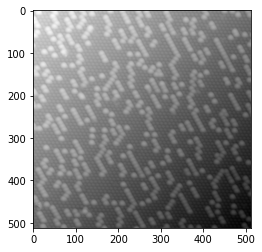

In [3]:
!gdown -q https://drive.google.com/uc?id=1ZBIOElSO4gkt0KUMwt0WlfFUYMIZK5ER

imgfile = nap.read.Scan('/content/Co3Sn2S2039.sxm')
topo = imgfile.signals['Z']['forward']

plt.imshow(topo, cmap='gray')

Do a standard 'background subtraction':

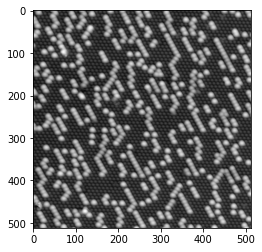

In [4]:
def subtract_plane(img: np.ndarray) -> np.ndarray:
 
    X1, X2 = np.mgrid[:img.shape[0], :img.shape[1]]
    X1, X2 = X1.reshape(-1, 1), X2.reshape(-1, 1)
    X = np.concatenate([np.ones((X1.shape[0], 1)), X1, X2], axis=1)
    Y = img.reshape(-1, 1)
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
    plane = np.dot(X, theta).reshape(*img.shape)
    Y_sub = Y.reshape(*img.shape) - plane
    
    return Y_sub

topo = subtract_plane(topo)
plt.imshow(topo, cmap='gray')

## Semantic segmentation

(Down)Load synthetic training/test data:

In [5]:
!gdown https://drive.google.com/uc?id=1-03RRw4Iy1y7rsLk_buNJrqDit_zezqL

Downloading...
From: https://drive.google.com/uc?id=1-03RRw4Iy1y7rsLk_buNJrqDit_zezqL
To: /content/Hex_train_test3.npz
1.68GB [00:06, 243MB/s]


In [6]:
dataset = np.load("Hex_train_test3.npz")
images = dataset["X_train"]
labels = dataset["y_train"]
images_test = dataset["X_test"]
labels_test = dataset["y_test"]

In [ ]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(1280, 1, 256, 256) (1280, 256, 256)
(320, 1, 256, 256) (320, 256, 256)


The training/test data are synthetic images of hexagonal lattice with two different type of atoms.

The training/test images and masks represent 4 separate numpy arrays with the dimensions (n_images, n_channels=1, image_height, image_width) for training/test images, and (n_images, image_height, image_width) for the associated masks (aka ground truth). The reason that our images have 4 dimensions, while our labels have only 3 dimensions is because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). Briefly, if you have multiple channels corresponding to different classes in your labeled data, you'll need to map your target classes to tensor indices. Here, we already did this for our training and test data during the preparation stage and so everything is ready for training.

Let's plot some of the training data:

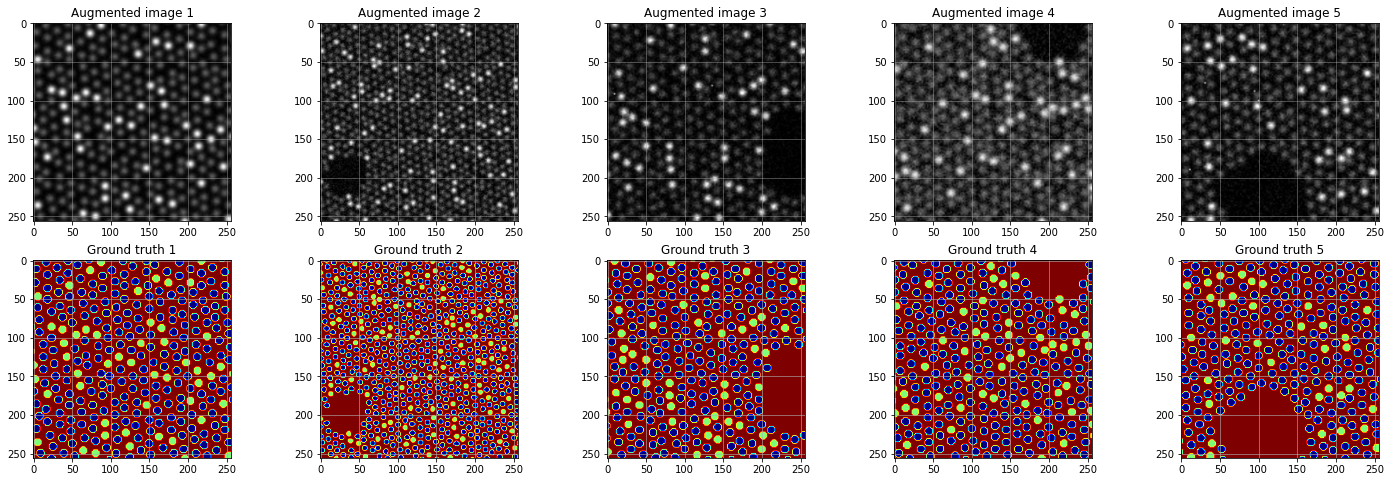

In [7]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

The neural network will be trained to take the images in the top row (see plot above) as the input and to output clean images of circular-shaped "blobs" on a uniform background in the bottom row, from which one can identify the xy centers of atoms.

We are going to use a [UNet](https://en.wikipedia.org/wiki/U-Net)-like neural network for semantic segmentation. In the semantic segmentation tasks we aim at categorizing every pixel in the image. This is different form a regular image-level classification tasks, where we categorize the image as whole (e.g. this image has a cat/dog, etc.). Here's a nice illustration from this [free book](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf):

<img src="https://drive.google.com/uc?export=view&id=18N4x3P0whH91OcpBOOkDprgWVo-36i34" width=800 px><br><br>

Initialize a nodel for semantic segmentation:

In [8]:
model = aoi.models.Segmentor(nb_classes=3)

We can also "print" the neural network:

In [9]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

Epoch 1/300 ... Training loss: 1.116 ... Test loss: 1.1329 ... Train Accuracy: 0.1559 ... Test Accuracy: 0.088 ... GPU memory usage: 5691/16280
Epoch 100/300 ... Training loss: 0.162 ... Test loss: 0.1616 ... Train Accuracy: 0.9103 ... Test Accuracy: 0.8979 ... GPU memory usage: 5691/16280
Epoch 200/300 ... Training loss: 0.1321 ... Test loss: 0.1046 ... Train Accuracy: 0.8984 ... Test Accuracy: 0.9209 ... GPU memory usage: 5691/16280
Epoch 300/300 ... Training loss: 0.1078 ... Test loss: 0.0862 ... Train Accuracy: 0.9124 ... Test Accuracy: 0.9218 ... GPU memory usage: 5691/16280
Model (final state) evaluation loss: 0.0982
Model (final state) IoU: 0.9125
Performing stochastic weight averaging...
Model (final state) evaluation loss: 0.0929
Model (final state) IoU: 0.9223
Plotting training history


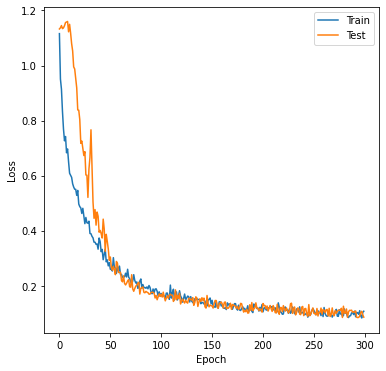

In [10]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True # training parameters
) 

In [11]:
nn_output, coordinates = model.predict(topo, thresh=0.95)  # thresh is a threshold for the softmax 'layer' of NN

Batch 1/1
1 image was decoded in approximately 0.1241 seconds


Plot predicted atomic coordinates:

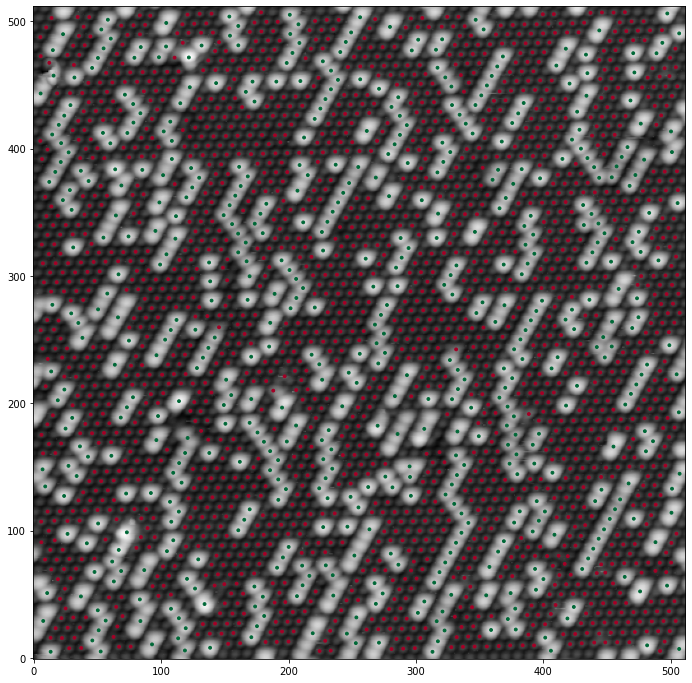

In [12]:
aoi.utils.plot_coord(topo, coordinates[0], fsize=12)

Looks like our model performed quite well on the previously unseen data! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky, but we can sometimes compare our results with the results of other methods.

Notice that here we analyzed image with resolution of 512x512 even though our network was trained only using 256x256 images. That's the beauty of fully convolutional neural networks (i.e. network without full-connected, dense layers) - it is not sensitive to the size of input image as long as it can be divided by $2^{n}$ where n is a number of max-pooling layers in the network. That said, there is always some optimal pixel-to-angstrom ratio (or, roughly, number of pixels per atom/defect) at which a network will generate the best results. It might be a good idea to determine such a ratio and (if possible) make adjustments to the resolution of experimental images.

Finally, please keep in mind that the model was trained only on synthetic data, so it may not be very robust or generalize well enough. However, the procedure for training on the larger and more diverse training set is exactly the same!